In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

# from tqdm.notebook import tqdm
# from tqdm import tqdm 

#not in scope of this course
from torchvision.datasets import CIFAR10
import torchvision.transforms as T
from torch.utils.data import DataLoader

from torch.optim import Adam


In [3]:
train_dataset = CIFAR10(".", download = True, train = True, transform = T.ToTensor())
test_dataset = CIFAR10(".", download = True, train = False, transform = T.ToTensor())

100.0%


Extracting .\cifar-10-python.tar.gz to .
Files already downloaded and verified


In [4]:
print("Class names:", train_dataset.classes)
print("\nNumber of classes:", len(train_dataset.classes))
print("\nClass to index:", train_dataset.class_to_idx)

print("\ntrain_dataset.data.shape",train_dataset.data.shape)
print("\ntest_dataset.data.shape",test_dataset.data.shape)
## 50k images for train
## 10k images for test
## 32*32*3 images


Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Number of classes: 10

Class to index: {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

train_dataset.data.shape (50000, 32, 32, 3)

test_dataset.data.shape (10000, 32, 32, 3)


In [5]:
bs = 64

train_loader = DataLoader(train_dataset, batch_size = bs)
test_loader = DataLoader(test_dataset, batch_size = bs)



print("Number of batches for train: ",len(train_loader))
print("Batch size for train: ",train_loader.batch_size)

print("Number of batches for test: ",len(test_loader))
print("Batch size for test: ",test_loader.batch_size)

print()
for images, labels in train_loader:
    print("Images: ",images.shape)
    print("Labels: ",labels.shape)
    break



Number of batches for train:  782
Batch size for train:  64
Number of batches for test:  157
Batch size for test:  64

Images:  torch.Size([64, 3, 32, 32])
Labels:  torch.Size([64])


In [40]:
class Model(nn.Module):
    def __init__(self, input, h1, h2, h3, output):
        super(Model, self).__init__()
        
        self.layer1 = nn.Linear(input, h1)
        self.layer2 = nn.Linear(h1, h2)
        self.layer3 = nn.Linear(h2, h3)
        self.layer4 = nn.Linear(h3, output)
        
        self.activaton = nn.ReLU()
        
    def forward(self, x):
        z1 = self.layer1(x)
        a1 = self.activaton(z1)
        
        z2 = self.layer2(a1)
        a2 = self.activaton(z2)
        
        z3 = self.layer3(a2)
        a3 = self.activaton(z3)
        
        z4 = self.layer4(a3)
        return z3

In [41]:
model = Model(32*32*3, 512, 256, 128, 10)

lr = 1e-3
epochs = 20


optimizer = Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss() # For multiClass

device = 'cuda' if torch.cuda.is_available() else 'cpu'  # checks if machine supports cuda and if it does, we use that, otherwise cpu
model.to(device)
print(f'Using device {device}')

Using device cuda


Epoch: 0, train_loss=1.8695194413757323
Epoch: 1, train_loss=1.6620381580352783
Epoch: 2, train_loss=1.567871316757202
Epoch: 3, train_loss=1.5051060040664672
Epoch: 4, train_loss=1.4630194829559326
Epoch: 5, train_loss=1.425515972137451
Epoch: 6, train_loss=1.3902883518981934
Epoch: 7, train_loss=1.3634907129287719
Epoch: 8, train_loss=1.3345712749481202
Epoch: 9, train_loss=1.3087782113647461
Epoch: 10, train_loss=1.2879632996368409
Epoch: 11, train_loss=1.2656706897354126
Epoch: 12, train_loss=1.24499235496521
Epoch: 13, train_loss=1.2270338820266724
Epoch: 14, train_loss=1.2051537104415893
Epoch: 15, train_loss=1.1936408696365357
Epoch: 16, train_loss=1.1828997336578368
Epoch: 17, train_loss=1.1703029961776734
Epoch: 18, train_loss=1.1560139784622192
Epoch: 19, train_loss=1.1387386043930054


Text(0, 0.5, 'Loss (Cross Entropy)')

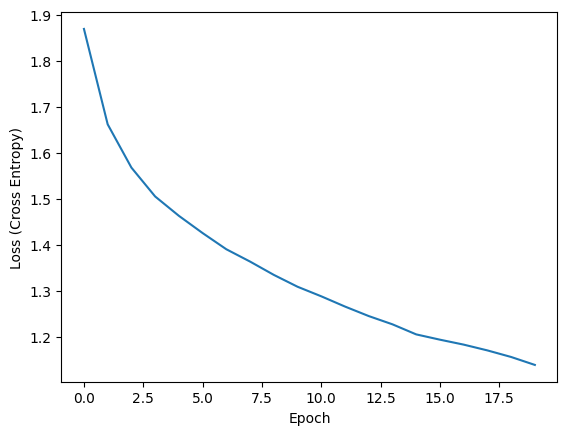

In [42]:
# Training 
train_losses = []

for epoch in range(epochs):
    model.train()   # Training Mode
    epoch_weighted_loss = 0     # Loss Counter (For plotting)
    
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.view(-1, 32*32*3).to(device)      
        batch_y = batch_y.to(device)      
        
        pred = model(batch_x)   # model output
        
        loss = criterion(pred, batch_y) # loss
        
        # Updating weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_weighted_loss += (len(batch_y)*loss.item()) # for plotting purpose
    
    epoch_loss = epoch_weighted_loss/len(train_loader.dataset)
    train_losses.append(epoch_loss)    # add loss for tracking
    print(f'Epoch: {epoch}, train_loss={epoch_loss}')

plt.plot(train_losses, label='train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Cross Entropy)')

    

In [43]:
model.eval()
correctly_labelled = 0 # for accuracy

# Same as training loop but without updating the weights
with torch.no_grad():
    val_epoch_weighted_loss = 0

    for batch_x, batch_y in test_loader:
        batch_x = batch_x.view(-1, 32*32*3).to(device)
        batch_y = batch_y.to(device)
        
        y_pred = model(batch_x)
        
        loss = criterion(y_pred, batch_y)
        
        val_epoch_weighted_loss += (len(batch_y)*loss.item())

        val_batch_y_pred = y_pred.argmax(dim=1)  # convert probailities to labels by picking the label (index) with the highest prob

        correctly_labelled += (val_batch_y_pred == batch_y).sum().item()  # item converts tensor to float/int/list

print(f'labelled {correctly_labelled}/{len(test_loader.dataset)} correctly ({correctly_labelled/len(test_loader.dataset)*100}% accuracy)')


labelled 5057/10000 correctly (50.57000000000001% accuracy)
